In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
import numpy as np
import matplotlib.pyplot as plt
import mne
from mne.preprocessing import ICA
from utils_neuro import *
import librosa
from tqdm import trange
from models import *


In [2]:
test5 = dataset_maker('data/test5_15.BDF',[0,1,11,13],0.5,40,15)
test6 = dataset_maker('data/test6.BDF',[0,1,5,9],0.5,40,10)
test7 = dataset_maker('data/test7.BDF',[1,2,3,4,5,8,11],0.5,40,10)
test8 = dataset_maker('data/test8_30.BDF',[1,3,7,8,12],0.5,40,30)
#test9 = dataset_maker('data/test9_5.BDF',[0],0.01,40,5) #-> it's under 5 min. must be error.
test10 = dataset_maker('data/test10_15.BDF',[1,3,4,8,9,12],0.5,40,15)
test11 = dataset_maker('data/test11_15.BDF',[2,4,5],0.5,40,15)
test12 = dataset_maker('data/test12.BDF',[0,1,4,6,9],0.5,40,10)
test13 = dataset_maker('data/test13_15.BDF',[1,4,5,11,13],0.5,40,15)
test14 = dataset_maker('data/test14_15.BDF',[0,1,2,4,5,6],0.5,40,15)
test15 = dataset_maker('data/test15_15.BDF',[0,1,3,8,12],0.5,40,15)
test16 = dataset_maker('data/test16_15.BDF',[0,1,2,3,4,5,7,12,13],0.5,40,15)
test17 = dataset_maker('data/test17_15.BDF',[0,1,2,3,9],0.5,40,15)



Extracting EDF parameters from /Users/axion66/coding/neuro_ai/data/test5_15.BDF...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 92799  =      0.000 ...   927.990 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (6.610 s)

Fitting ICA to data using 16 channels (please be patient, this may take a while)
Selecting by number: 16 components
Fitting ICA took 7.8s.

In [3]:
final_data = torch.cat((test5,test6,test7,test8,test10,test11,test12,test13,test14,test15,test16,test17),dim=0)
final_data = final_data.permute(0,2,1)
print(f"final_data.shape: {final_data.shape}") #torch.Size([1800, 300, 16])
labels = label_taker([15,10,10,30,15,15,10,15,15,15,15,15])
print(f"len(labels) : {len(labels)}") # (1800,)

final_data.shape: torch.Size([1800, 300, 16])
len(labels) : 1800


In [4]:
a, b = ERP(final_data,labels)
print(a.shape)
print(b.shape)

word1 = b[2,:,:,:]
word2 = b[5,:,:,:]

torch.Size([10, 16, 300])
torch.Size([10, 16, 180, 300])


In [5]:
word1 = word1.permute(1,0,2)
word2 = word2.permute(1,0,2)
print(word1.shape)
print(word2.shape)


torch.Size([180, 16, 300])
torch.Size([180, 16, 300])


In [6]:
word3and6 = torch.cat((word1,word2))
word3and6 = word3and6.permute(0,2,1)
print(word3and6.shape)

label0 = [0 for i in range(180)]
label1 = [1 for i in range(180)]
label3 = label0 + label1
print(len(label3))

torch.Size([360, 300, 16])
360


In [7]:
class dataset1(nn.Module):
    def __init__(self,data,label):
        
        self.data = (data - data.mean()) / data.std()
        self.label = label
        
    def __len__(self):
        if len(self.label) != self.data.shape[0]:
            raise Exception(f"data.shape: {self.data.shape} and label.len: {len(self.label)}, and error occured")
        
        return self.data.shape[0]
    
    def __getitem__(self,idx):
        return self.data[idx,:,:], self.label[idx]
    
dat = dataset1(word3and6,label3)

In [8]:
# config
dLoader = DataLoader(dat,batch_size=16,shuffle=True)

class NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.LSTM(16,48)
        self.fc1 = nn.Sequential(
            nn.Linear(48,24),
            nn.GELU(),
            nn.Linear(24,1)
        )
    def forward(self,x):
        print(x.shape)
        x,_= self.layer1(x)
        x = x[:,-1,:]
        x = self.fc1(x)
        x = x.squeeze(-1)
        return torch.sigmoid(x) 
    
model = NN()
optimizer = optim.Adam(model.parameters(),lr=3e-5)
loss_fn = nn.BCELoss()



torch.Size([16, 300, 16])
tensor([0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0])
torch.Size([16, 300, 16])
tensor([0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1])
torch.Size([16, 300, 16])
tensor([0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0])
torch.Size([16, 300, 16])
tensor([1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1])
torch.Size([16, 300, 16])
tensor([1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0])
torch.Size([16, 300, 16])
tensor([0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0])
torch.Size([16, 300, 16])
tensor([1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1])
torch.Size([16, 300, 16])
tensor([1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0])
torch.Size([16, 300, 16])
tensor([0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1])
torch.Size([16, 300, 16])
tensor([0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0])
torch.Size([16, 300, 16])
tensor([0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1])
torch.Size([16, 300, 16])
tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0])
torc

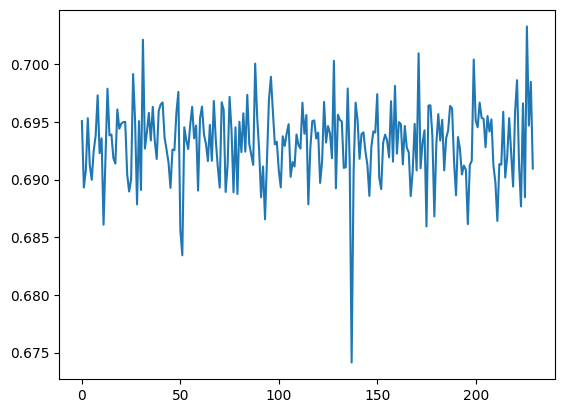

In [9]:
losses = []
for i in range(10):
    for d,l in dLoader:
        optimizer.zero_grad()
        output = model(d)
        print(l)
        loss = loss_fn(output.float(),l.float())
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
        
        
plt.plot(losses)

In [11]:
model.eval()

for dd,ll in dLoader:
    output = model(dd)
    print(output)
    print(ll)

model.train()

torch.Size([16, 300, 16])
tensor([0.4953, 0.4968, 0.4958, 0.4987, 0.4956, 0.4955, 0.4939, 0.4944, 0.4945,
        0.4940, 0.4931, 0.4939, 0.4957, 0.4930, 0.4967, 0.4985],
       grad_fn=<SigmoidBackward0>)
tensor([1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1])
torch.Size([16, 300, 16])
tensor([0.4849, 0.4887, 0.4934, 0.4886, 0.4890, 0.4905, 0.4914, 0.4956, 0.4965,
        0.4899, 0.4953, 0.4968, 0.4945, 0.4941, 0.4949, 0.4859],
       grad_fn=<SigmoidBackward0>)
tensor([0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0])
torch.Size([16, 300, 16])
tensor([0.4953, 0.4960, 0.4952, 0.4949, 0.4945, 0.4972, 0.4953, 0.4992, 0.4962,
        0.4860, 0.4844, 0.4936, 0.4953, 0.4969, 0.4970, 0.4959],
       grad_fn=<SigmoidBackward0>)
tensor([1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1])
torch.Size([16, 300, 16])
tensor([0.4945, 0.4943, 0.4930, 0.4947, 0.4897, 0.4942, 0.4931, 0.4939, 0.4949,
        0.4953, 0.4901, 0.4903, 0.4916, 0.4939, 0.4959, 0.4973],
       grad_fn=<SigmoidBackward0>)
tenso

NN(
  (layer1): LSTM(16, 48)
  (fc1): Sequential(
    (0): Linear(in_features=48, out_features=24, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=24, out_features=1, bias=True)
  )
)